# CS576 Assignment #3: Object Detection Using YOLO v1
---
Primary TA : 
* Jaehoon Yoo (wogns98@kaist.ac.kr)
* Whie Jung (whieya@kaist.ac.kr)
---

## Instruction
- In this assignment, you will implement, train, and test Yolo v1 on Pascal VOC Detection dataset with 20 object categories (`'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'`).

- For this, you need to implement (1) architecture, (2) loss function, (3) training/testing pipeline, and (4) inference function.

- In each part, you will be given a starter code for the implementation. Please read instructions carefully to implement the codes.  

- In this assignment, we will provide you with pre-trained weights of the Yolo architecture to reduce the amount of time required for the convergence and thus ease your burden on the training. This pre-trained weights will automatically loaded to your network if you implemented it correctly.

- <font color="red"> It takes at least 6 mins per epoch, so you need at least 6*50=300 mins for the whole training. So please get started as early as possible. </font> 



## Submission guidelines
- Your code and report will be all in Colab. 
- Go to the [link](https://drive.google.com/drive/folders/1QboYl5LfKPXTijS_Cmt_UyHMMZlFzJUo?usp=sharing), make a copy of `assignment3.ipynb`, `data.py`, `dataset.zip`, `test_images.zip`, and make `weights` directory into your own google drive. Find the copies in your drive, recover their names to original ones if their names were changed to e.g. `Copy of assignment3.ipynb` or `assignment3.ipynb의 사본`. Also, keep them in a single directory.
- <font color="red"> You will get the full credit **only if** you complete the code **and** write a discussion of the results in the discussion section at the bottom of this page. Please refer to the discussion section for the details. </font> 
- We should be able to reproduce your results using your code. Please double-check if your code runs without error and reproduces your results. Submissions failed to run or reproduce the results will get a substantial penalty. 

## Deliverables
- Your Colab notebook with name of **[StudentID].ipynb**
- Result images (`1_result.jpg`, `2_result.jpg`, ...). Please refer to Problem 4.
- Saved checkpoint (`last.pth`). This will be saved automatically in your `checkpoints` directory. 
- Submit all of them in a format as : **[StudentID].zip**.
- **If your submission doesn't contain all of the above deliverables , you will lose a point for deliverable (5pt).**
- Your assignment should be submitted through KLMS. All other submissions (e.g., via email) will not be considered as valid submissions.


## Due date
- **23:59:59 June 2nd.**
- Late submission is allowed until 23:59:59 June 4th.
- Late submission will be applied 20% penalty.

## Questions
- Please use QnA board in KLMS as a main communication channel. When you post questions, please make it public so that all students can share the information. Please use the prefix "[Assignment 3]" in the subject for all questions regarding this assignment (e.g., [Assignment 3] Regarding the grading policy).

## Plagiarism
- <font color="red"> Do not copy public codes or your classmate's code. We will strictly detect the plagiarism. All codes with plagiarism will be considered as 0 point.

## Changelog

- Add .item() to clamp functions in the NMS function.

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
# Specify the directory path where `assignemnt3.ipynb` and `dataset.zip` exist.
# For example, if you saved `assignment3.ipynb` `/gdrive/My Drive/cs576/assignment3` directory,
# then set root = '/gdrive/My Drive/cs576/assignment3'
root = '/gdrive/My Drive/ComputervisionCS576/Homework3'

!ln -s '/gdrive/My Drive'/{root.replace('/gdrive/My Drive/', '')}/weights ./
!unzip -q '/gdrive/My Drive'/{root.replace('/gdrive/My Drive/', '')}/dataset.zip
!unzip -q '/gdrive/My Drive'/{root.replace('/gdrive/My Drive/', '')}/test_images.zip

In [ ]:
import sys
sys.path.append(root)

import warnings
warnings.filterwarnings("ignore")

import os
import cv2
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms

from data import VOCDetection
def makedirs(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [ ]:
# Configurations
run_name = 'vgg16'          # experiment name.
ckpt_root = 'checkpoints'   # from/to which directory to load/save checkpoints.
data_root = 'dataset'       # where the data exists.
pretrained_backbone_path = 'weights/vgg_features.pth'

device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 0.001          # learning rate
batch_size = 64     # batch_size
last_epoch = 1      # the last training epoch. (defulat: 1)
max_epoch = 50     # maximum epoch for the training.

num_boxes = 2       # the number of boxes for each grid in Yolo v1.
num_classes = 20    # the number of classes in Pascal VOC Detection.
grid_size = 7       # 3x224x224 image is reduced to (5*num_boxes+num_classes)x7x7.
lambda_coord = 7    # weight for coordinate regression loss.
lambda_noobj = 0.5  # weight for no-objectness confidence loss.

ckpt_dir = os.path.join(root, ckpt_root)
makedirs(ckpt_dir)
!ln -s '/gdrive/My Drive'/{ckpt_dir.replace('/gdrive/My Drive/', '')} ./

In [ ]:
train_dset = VOCDetection(root=data_root, split='train')
train_dloader = DataLoader(train_dset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=8)

test_dset = VOCDetection(root=data_root, split='test')
test_dloader = DataLoader(test_dset, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=8)

# Problem 1. Implement Architecture (10pt) [(Illustration)](https://docs.google.com/drawings/d/1DNWgMK0XNQJ1IZPxX3u_ger7s-iQpAHG0pI_6A5dAPs/edit?usp=sharing)

In this section, you need to implement two modularized networks for Yolo v1:

(1) Backbone network of Yolo v1, extracting feature representations ($N, 512, 7, 7$) on input images ($N, 3, 224, 224$),  
(2) Detection network of Yolo v1, predicting object confidences, classes, and their locations based on grids ($N, S, S, B\times5+C$),

where $N, S, B, C$ refer to the batch size, grid size, the number of boxes for each grid, and the number of object classes, respectively.

For more details about the network architecture, please refer to the illustration.

Below, you will be provided with a skeleton python class for Yolo.  
Please fill in the `self.features = nn.Sequential(...)` and `self.detector = nn.Sequential(...)` to implement this module.

In [ ]:
class Yolo(nn.Module):
    def __init__(self, grid_size, num_boxes, num_classes):
        super(Yolo, self).__init__()
        self.S = grid_size
        self.B = num_boxes
        self.C = num_classes
        self.features = nn.Sequential(
            # P1.1. implement VGG16 backbone network here.
            nn.Conv2d(3,64,kernel_size=(3,3), stride=(1,1),padding=(1,1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2,padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(64, 128, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.ReLU(inplace=True), 
            nn.Conv2d(128, 128, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.ReLU(inplace=True), 
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), 
            nn.Conv2d(128, 256, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.ReLU(inplace=True), 
            nn.Conv2d(256, 256, kernel_size=(3,3), stride=(1,1), padding=(1,1)), 
            nn.ReLU(inplace=True), 
            nn.Conv2d(256, 256, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.ReLU(inplace=True), 
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(256, 512, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.ReLU(inplace=True), 
            nn.Conv2d(512, 512, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.ReLU(inplace=True), 
            nn.Conv2d(512, 512, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.ReLU(inplace=True), 
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), 
            nn.Conv2d(512, 512, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.ReLU(inplace=True), 
            nn.Conv2d(512, 512, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.ReLU(inplace=True), 
            nn.Conv2d(512, 512, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.ReLU(inplace=True), 
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        self.detector = nn.Sequential(
            # P1.2. implement detection head here.
            nn.Linear(in_features=512*self.S*self.S, out_features=4096, bias=True), 
            nn.ReLU(inplace=True), 
            nn.Dropout(p=0.5, inplace=False), 
            nn.Linear(in_features=4096, out_features=self.S*self.S*(self.B*5+self.C), bias=True)
        )
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.detector(x)
        x = F.sigmoid(x)
        x = x.view(-1, self.S, self.S, self.B*5+self.C)
        return x

model = Yolo(grid_size, num_boxes, num_classes)
model = model.to(device)
pretrained_weights = torch.load(pretrained_backbone_path)
model.load_state_dict(pretrained_weights)

# It should print out <All keys matched successfully> when you implemented VGG correctly.

<All keys matched successfully>

In [ ]:
# Freeze the backbone network.
model.features.requires_grad_(False)
model_params = [v for v in model.parameters() if v.requires_grad is True]
optimizer = optim.SGD(model_params, lr=lr, momentum=0.9, weight_decay=5e-4)

# Load the last checkpoint if exits.
ckpt_path = os.path.join(ckpt_dir, 'last.pth') 

if os.path.exists(ckpt_path): 
    ckpt = torch.load(ckpt_path)
    model.load_state_dict(ckpt['model'])
    optimizer.load_state_dict(ckpt['optimizer'])
    last_epoch = ckpt['epoch'] + 1
    print('Last checkpoint is loaded. start_epoch:', last_epoch)
else:
    print('No checkpoint is found.')

Last checkpoint is loaded. start_epoch: 50


# Problem 2. Implement Loss Function (15pt)

In this section, you need to implement code for computing losses in Yolo.  
Below, you will be provided with a skeleton module class, where you need to complete the forward function:  
`def forward(self, pred_tensor, target_tensor): 
...
return loss_xy, loss_wh, loss_obj, loss_noobj, loss_class`

where $N, S, B, C$ refer to the batch size, grid size, the number of boxes for each grid, and the number of object classes, respectively.

To get an easy picture on how `pred_tensor` and `target_tensor` look like, refer to the page 18~25 in [this slide](https://docs.google.com/presentation/d/1aeRvtKG21KHdD5lg6Hgyhx5rPq_ZOsGjG5rJ1HP7BbA/pub?start=false&loop=false&delayms=3000&slide=id.g137784ab86_4_1187)

Refer to the paper for more details about the loss function: https://arxiv.org/pdf/1506.02640.pdf

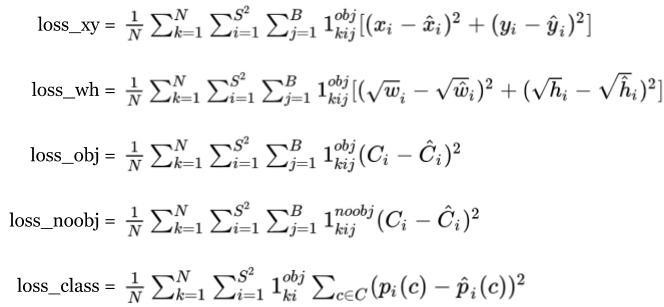

In [ ]:
class Loss(nn.Module):
    def __init__(self, grid_size=7, num_bboxes=2, num_classes=20):
        """ Loss module for Yolo v1.
        Use grid_size, num_bboxes, num_classes information if necessary.

        Args:
            grid_size: (int) size of input grid.
            num_bboxes: (int) number of bboxes per each cell.
            num_classes: (int) number of the object classes.
        """
        super(Loss, self).__init__()
        self.S = grid_size
        self.B = num_bboxes
        self.C = num_classes

    def compute_iou(self, bbox1, bbox2):
        """ Compute the IoU (Intersection over Union) of two set of bboxes, each bbox format: [x1, y1, x2, y2].
        Use this function if necessary.

        Args:
            bbox1: (Tensor) bounding bboxes, sized [N, 4].
            bbox2: (Tensor) bounding bboxes, sized [M, 4].
        Returns:
            (Tensor) IoU, sized [N, M].
        """
        N = bbox1.size(0)
        M = bbox2.size(0)

        # Compute left-top coordinate of the intersections
        lt = torch.max(
            bbox1[:, :2].unsqueeze(1).expand(N, M, 2), # [N, 2] -> [N, 1, 2] -> [N, M, 2]
            bbox2[:, :2].unsqueeze(0).expand(N, M, 2)  # [M, 2] -> [1, M, 2] -> [N, M, 2]
        )
        # Conpute right-bottom coordinate of the intersections
        rb = torch.min(
            bbox1[:, 2:].unsqueeze(1).expand(N, M, 2), # [N, 2] -> [N, 1, 2] -> [N, M, 2]
            bbox2[:, 2:].unsqueeze(0).expand(N, M, 2)  # [M, 2] -> [1, M, 2] -> [N, M, 2]
        )
        # Compute area of the intersections from the coordinates
        wh = rb - lt   # width and height of the intersection, [N, M, 2]
        wh[wh < 0] = 0 # clip at 0
        inter = wh[:, :, 0] * wh[:, :, 1] # [N, M]

        # Compute area of the bboxes
        area1 = (bbox1[:, 2] - bbox1[:, 0]) * (bbox1[:, 3] - bbox1[:, 1]) # [N, ]
        area2 = (bbox2[:, 2] - bbox2[:, 0]) * (bbox2[:, 3] - bbox2[:, 1]) # [M, ]
        area1 = area1.unsqueeze(1).expand_as(inter) # [N, ] -> [N, 1] -> [N, M]
        area2 = area2.unsqueeze(0).expand_as(inter) # [M, ] -> [1, M] -> [N, M]

        # Compute IoU from the areas
        union = area1 + area2 - inter # [N, M, 2]
        iou = inter / union           # [N, M, 2]

        return iou

    def forward(self, pred_tensor, target_tensor):
        """ Compute loss.

        Args:
            pred_tensor (Tensor): predictions, sized [batch_size, S, S, Bx5+C], 5=len([x, y, w, h, conf]).
            target_tensor (Tensor):  targets, sized [batch_size, S, S, Bx5+C].
        Returns:
            loss_xy (Tensor): localization loss for center positions (x, y) of bboxes.
            loss_wh (Tensor): localization loss for width, height of bboxes.
            loss_obj (Tensor): objectness loss.
            loss_noobj (Tensor): no-objectness loss.
            loss_class (Tensor): classification loss.
        """
        # P2. Write your code here
        N = pred_tensor.size()[0]
        length_vector = 5* self.B + self.C
        obj_mask = target_tensor[:, :, :, 4] > 0
        noobj_mask = target_tensor[:, :, :, 4] == 0
        obj_mask = obj_mask.unsqueeze(-1).expand_as(target_tensor)
        noobj_mask = noobj_mask.unsqueeze(-1).expand_as(target_tensor)

        obj_pred = pred_tensor[obj_mask].view(-1, length_vector)
        bbox_pred = obj_pred[:, :5 * self.B].contiguous().view(-1, 5)
        class_pred = obj_pred[:, 5 * self.B:]

        obj_target = target_tensor[obj_mask].view(-1, length_vector)
        bbox_target = obj_target[:, :5*self.B].contiguous().view(-1,5)
        class_target = obj_target[:, 5*self.B:]
        # compute loss_class
        loss_class = F.mse_loss(class_pred, class_target, reduction='sum')/N

        # compute loss_noobj
        noobj_pred = pred_tensor[noobj_mask].view(-1, length_vector)
        noobj_target = target_tensor[noobj_mask].view(-1, length_vector)
        noobj_pred_mask = torch.cuda.ByteTensor(noobj_pred.size())
        noobj_pred_mask.zero_()
        for i in range(self.B):
            noobj_pred_mask[:, 5*i+4] = 1
        noobj_pred_c = noobj_pred[noobj_pred_mask]
        noobj_target_c = noobj_target[noobj_pred_mask]
        loss_noobj = F.mse_loss(noobj_pred_c, noobj_target_c, reduction='sum')/N

        # compute loss_obj
        obj_relevant_mask = torch.cuda.ByteTensor(bbox_target.size())
        obj_relevant_mask.zero_()
        obj_not_relevant_mask = torch.cuda.ByteTensor(bbox_target.size())
        obj_not_relevant_mask.zero_()
        bbox_target_iou = torch.zeros(bbox_target.size()).cuda()
        for i in range(0, bbox_target.size()[0], self.B):
            bbox1 = bbox_pred[i:i + self.B]
            bbox1_xyxy = Variable(torch.FloatTensor(bbox1.size()))
            bbox1_xyxy[:, :2] = bbox1[:, :2]/float(self.S) - 0.5 * bbox1[:, 2:4]
            bbox1_xyxy[:, 2:4] = bbox1[:, :2]/float(self.S) + 0.5 * bbox1[:, 2:4]

            bbox2 = bbox_target[i].view(-1, 5)
            bbox2_xyxy = Variable(torch.FloatTensor(bbox2.size()))
            bbox2_xyxy[:, :2] = bbox2[:, :2]/float(self.S) - 0.5 * bbox2[:, 2:4]
            bbox2_xyxy[:, 2:4] = bbox2[:, :2]/float(self.S) + 0.5 * bbox2[:, 2:4]

            iou = self.compute_iou(bbox1_xyxy[:, :4], bbox2_xyxy[:, :4])
            max_iou_, max_index_ = iou.max(0)
            max_index_ = max_index_.data.cuda()

            obj_relevant_mask[i + max_index_] = 1
            for j in range(0, self.B):
                if j != max_index_:
                    obj_not_relevant_mask[i + j] = 1

            bbox_target_iou[i + max_index_, torch.LongTensor([4]).cuda()] = (max_iou_).data.cuda()
        bbox_target_iou = Variable(bbox_target_iou).cuda()

        # compute loss_obj, loss_xy, loss_wh
        bbox_pred_relevant = bbox_pred[obj_relevant_mask].view(-1, 5)
        bbox_target_relevant_iou = bbox_target_iou[obj_relevant_mask].view(-1, 5)
        bbox_target_relevant = bbox_target[obj_relevant_mask].view(-1, 5)
        loss_obj = F.mse_loss(bbox_pred_relevant[:, 4], bbox_target_relevant_iou[:, 4], reduction='sum')/N
        loss_xy = F.mse_loss(bbox_pred_relevant[:, :2], bbox_target_relevant[:, :2], reduction='sum')/N
        loss_wh = F.mse_loss(torch.sqrt(bbox_pred_relevant[:, 2:4]), torch.sqrt(bbox_target_relevant[:, 2:4]), reduction='sum')/N
        
        return loss_xy, loss_wh, loss_obj, loss_noobj, loss_class

compute_loss = Loss(grid_size, num_boxes, num_classes)

# Problem 3. Implement Train/Test Pipeline (10pt)

In this section, you need to implement the entire train and test loop in the pipeline.

Specifically, you need to do the followings:
1. set proper device for the inputs (x) / labels (y).
2. feed inputs into the network, get outputs, compute loss using your implemented loss function from problem 2.   
(Don't forget to aggregate them all to calculate a single final loss, using lambda_coord and lambda_noobj).
3. backward the computed loss and update network weights (only in the training loop).

* **Expected training time (for reference)** : About 6 minute / epoch.

In [ ]:
# Training & Testing.
model = model.to(device)
for epoch in range(1, max_epoch):
    # Learning rate scheduling
    if epoch in [50, 150]:
        lr *= 0.1
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

    if epoch < last_epoch:
        continue

    model.train()
    train_loss = 0.
    train_num_data = 0.
    for x, y in train_dloader:
        # P3.1. implement training pipeline here
        # x.shape = [64, 3, 224, 224]
        # y.shape = [64, 7, 7, 30]
        x = x.to(device)
        y = y.to(device)

        pred_ = model(x) 
        loss_xy_, loss_wh_, loss_obj_, loss_noobj_, loss_class_ = compute_loss(pred_, y)
        # lambda_coord = 7, lambda_noobj = 0.5
        loss = lambda_coord*loss_xy_ + lambda_coord*loss_wh_ + loss_obj_ + lambda_noobj*loss_noobj_ + loss_class_
        
        train_loss += loss.item()*x.shape[0]
        train_num_data += x.shape[0]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss = train_loss/train_num_data

    model.eval()
    test_loss = 0.
    test_num_data = 0.
    with torch.no_grad():
        for x, y in test_dloader:
           # P3.2. implement testing pipeline here
           x = x.to(device)
           y = y.to(device)
           pred_ = model(x) 
           loss_xy_, loss_wh_, loss_obj_, loss_noobj_, loss_class_ = compute_loss(pred_, y)
           loss = lambda_coord*loss_xy_ + lambda_coord*loss_wh_ + loss_obj_ + lambda_noobj*loss_noobj_ + loss_class_

           test_loss += loss.item()*x.shape[0]
           test_num_data += x.shape[0]
    test_loss = test_loss/test_num_data      
    print("Epoch {} ||".format(epoch) + "train_loss = " + str(train_loss) + ", test_loss = " + str(test_loss) )

    ckpt = {'model':model.state_dict(),
            'optimizer':optimizer.state_dict(),
            'epoch':epoch}
    torch.save(ckpt, ckpt_path)

Epoch 1 ||train_loss = 3.6419428894485253, test_loss = 3.8563213068604396
Epoch 2 ||train_loss = 3.362170570484106, test_loss = 3.6306921887267745
Epoch 3 ||train_loss = 3.2417539790056753, test_loss = 3.4869827638127977
Epoch 4 ||train_loss = 3.092939433498659, test_loss = 3.381664097513774
Epoch 5 ||train_loss = 3.0050837447677834, test_loss = 3.296485218080071
Epoch 6 ||train_loss = 2.9561042858206705, test_loss = 3.2452781652590406
Epoch 7 ||train_loss = 2.9031633442726688, test_loss = 3.2082514961761217
Epoch 8 ||train_loss = 2.8335346757501796, test_loss = 3.137389938028575
Epoch 9 ||train_loss = 2.7859426761019055, test_loss = 3.1063998386947054
Epoch 10 ||train_loss = 2.7462200613989345, test_loss = 3.0770223876053193
Epoch 11 ||train_loss = 2.744986050716345, test_loss = 3.038830908927694
Epoch 12 ||train_loss = 2.6929041458212812, test_loss = 3.0037570070965174
Epoch 13 ||train_loss = 2.6679396591324736, test_loss = 2.9738731471439053
Epoch 14 ||train_loss = 2.634740532308385

# Problem 4. Implement decoder to extract bounding boxes from output-grids (15pt)


In this section, you need to implement the decoder for extracting bounding boxes from given output grids ($S, S, B \times 5 + 20$). You should complete `decoder` function with given `NMS`(Non Max Suppression) function. 

If you implement it well, you can perform object dection on the given image and get the result through `inference` function.

Check `test_images` directory and find `X_result.jpg` files if you succeeded to run `inference` function, and **attach these files in the discussion section**. 

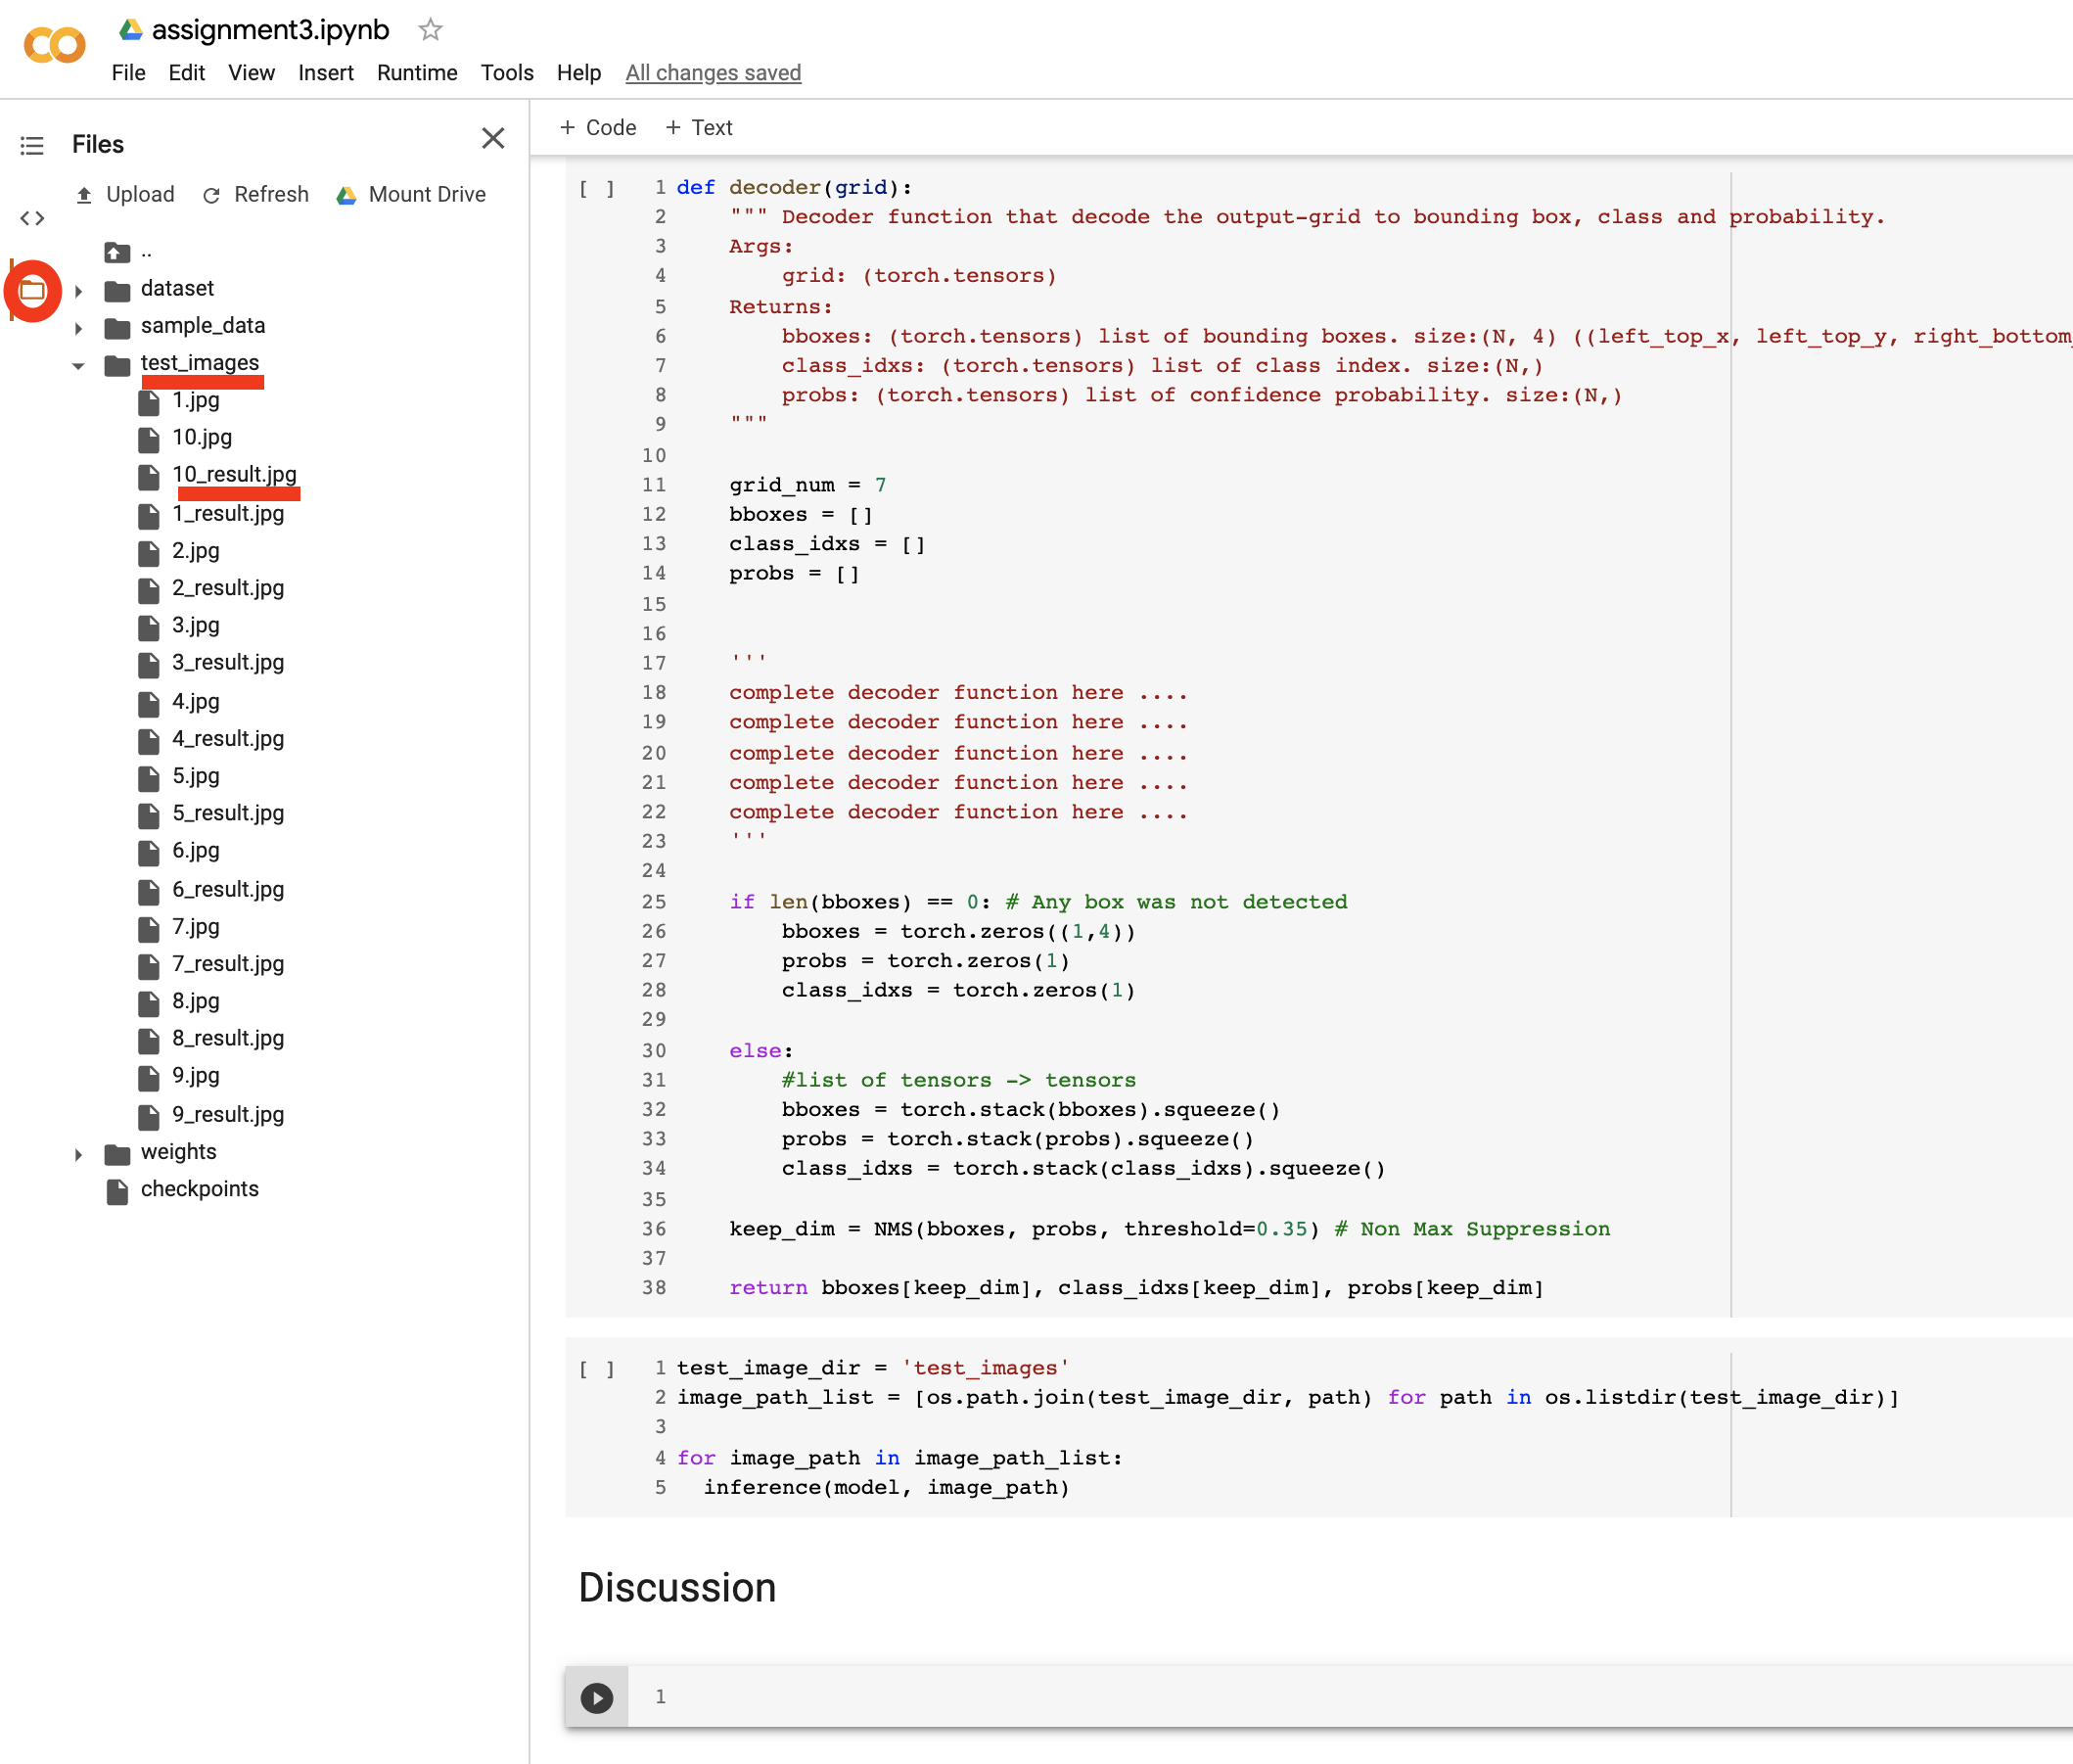

In [ ]:
VOC_CLASSES = (
    'aeroplane', 'bicycle', 'bird', 'boat',
    'bottle', 'bus', 'car', 'cat', 'chair',
    'cow', 'diningtable', 'dog', 'horse',
    'motorbike', 'person', 'pottedplant',
    'sheep', 'sofa', 'train', 'tvmonitor')

def NMS(bboxes, scores, threshold=0.35):
    ''' Non Max Suppression
    Args:
        bboxes: (torch.tensors) list of bounding boxes. size:(N, 4) ((left_top_x, left_top_y, right_bottom_x, right_bottom_y), (...))
        probs: (torch.tensors) list of confidence probability. size:(N,) 
        threshold: (float)   
    Returns:
        keep_dim: (torch.tensors)
    '''
    x1 = bboxes[:, 0]
    y1 = bboxes[:, 1]
    x2 = bboxes[:, 2]
    y2 = bboxes[:, 3]

    areas = (x2 - x1) * (y2 - y1)

    _, order = scores.sort(0, descending=True)
    keep = []
    while order.numel() > 0:
        try:
            i = order[0]
        except:
            i = order.item()
        keep.append(i)

        if order.numel() == 1: break

        xx1 = x1[order[1:]].clamp(min=x1[i].item())
        yy1 = y1[order[1:]].clamp(min=y1[i].item())
        xx2 = x2[order[1:]].clamp(max=x2[i].item())
        yy2 = y2[order[1:]].clamp(max=y2[i].item())

        w = (xx2 - xx1).clamp(min=0)
        h = (yy2 - yy1).clamp(min=0)
        inter = w * h

        ovr = inter / (areas[i] + areas[order[1:]] - inter)
        ids = (ovr <= threshold).nonzero().squeeze()
        if ids.numel() == 0:
            break
        order = order[ids + 1]
    keep_dim = torch.LongTensor(keep)
    return keep_dim

In [ ]:
def inference(model, image_path):
    """ Inference function
    Args:
        model: (nn.Module) Trained YOLO model.
        image_path: (str) Path for loading the image.
    """
    # load & pre-processing
    image_name = image_path.split('/')[-1]
    image = cv2.imread(image_path)

    h, w, c = image.shape
    img = cv2.resize(image, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    transform = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    img = transform(torch.from_numpy(img).float().div(255).transpose(2, 1).transpose(1, 0)) #Normalization
    img = img.unsqueeze(0)
    img = img.to(device)

    # inference
    output_grid = model(img).cpu()

    #### YOU SHOULD IMPLEMENT FOLLOWING decoder FUNCTION ####
    # decode the output grid to the detected bounding boxes, classes and probabilities.
    bboxes, class_idxs, probs = decoder(output_grid)
    num_bboxes = bboxes.size(0)

    # draw bounding boxes & class name
    for i in range(num_bboxes):
        bbox = bboxes[i]
        class_name = VOC_CLASSES[class_idxs[i]]
        prob = probs[i]

        x1, y1 = int(bbox[0] * w), int(bbox[1] * h)
        x2, y2 = int(bbox[2] * w), int(bbox[3] * h)

        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(image, '%s: %.2f'%(class_name, prob), (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 255), 1,
                    8)

    cv2.imwrite(image_name.replace('.jpg', '_result.jpg'), image)

In [ ]:
def decoder(grid):
    """ Decoder function that decode the output-grid to bounding box, class and probability. 
    Args:
        grid: (torch.tensors)
    Returns:
        bboxes: (torch.tensors) list of bounding boxes. size:(N, 4) ((left_top_x, left_top_y, right_bottom_x, right_bottom_y), (...))
        class_idxs: (torch.tensors) list of class index. size:(N,)
        probs: (torch.tensors) list of confidence probability. size:(N,)
    """

    grid_num = 7
    bboxes = []
    class_idxs = []
    probs = []

    # P4 Implement the decoder function
    cell_size_ = 1.0 / float(grid_num)
    grid = grid.data
    grid = grid.squeeze(0)  # now grid.shape = torch.Size([7, 7, 30])

    for i in range(grid_num):
        for j in range(grid_num):
            class_score, class_label = torch.max(grid[j, i, 5 * num_boxes:], 0)
            for b in range(num_boxes):
                confidence = torch.FloatTensor([grid[j, i, 5 * b + 4]])
                probability = confidence * class_score
                # probability =  tensor([0.0024])

                # compute the coords [x1, y1, x2, y2] for boxes
                bbox = grid[j, i, 5 * b: 5 * b + 4]
                x0y0_normalized_ = torch.FloatTensor([i, j]) * cell_size_
                xy_normalized_ = bbox[:2] * cell_size_ + x0y0_normalized_
                wh_normalized_ = bbox[2:]

                bbox_xyxy = torch.FloatTensor(4)
                bbox_xyxy[:2] = xy_normalized_ - 0.5 * wh_normalized_  # left-top corner (x1, y1).
                bbox_xyxy[2:] = xy_normalized_ + 0.5 * wh_normalized_  # right-bottom corner (x2, y2).

                if float(probability[0]) > 0.1:
                    bboxes.append(bbox_xyxy.view(1,4))
                    class_idxs.append(class_label.view(1))
                    probs.append(probability)
    ##########################
    
    if len(bboxes) == 0: # Any box was not detected
        bboxes = torch.zeros((1,4))
        probs = torch.zeros(1)
        class_idxs = torch.zeros(1, dtype=torch.int)             # for bugs I changed
        
    else: 
        #list of tensors -> tensors
        ## for bugs I changed ##
        bboxes = torch.cat(bboxes, dim=0)
        probs = torch.cat(probs, dim=0)
        class_idxs = torch.cat(class_idxs, dim=0)

    # Modified version : It applies nms class by class. 
    bboxes_result, class_idxs_result, probs_result = [], [], []
    for label in range(num_classes):
        label_mask = (class_idxs==label)
        if label_mask.sum() > 0:
            _bboxes = bboxes[label_mask]
            _probs = probs[label_mask]
            _class_idxs = class_idxs[label_mask]
            
            keep_dim = NMS(_bboxes, _probs, threshold=0.16) # Non Max Suppression
            bboxes_result.append(_bboxes[keep_dim])
            class_idxs_result.append(_class_idxs[keep_dim])
            probs_result.append(_probs[keep_dim])

    bboxes_result = torch.cat(bboxes_result, 0)
    class_idxs_result = torch.cat(class_idxs_result, 0)
    probs_result = torch.cat(probs_result, 0)

    return bboxes_result, class_idxs_result, probs_result

    # # Original Code.     
    # keep_dim = NMS(bboxes, probs, threshold=0.16) # Non Max Suppression

    # return bboxes[keep_dim], class_idxs[keep_dim], probs[keep_dim]

In [ ]:
test_image_dir = 'test_images'
image_path_list = [os.path.join(test_image_dir, path) for path in os.listdir(test_image_dir)]
model.eval()

for image_path in image_path_list:
  inference(model, image_path)

# Discussion (15pt)
In this section, you should summarize your results with your analysis on them. Since implementation of YOLO is already dense, you don't need to conduct your own experiments this time. Instead, provide a disucssion on YOLO. At least, your discussion must include following items.
* Provide at least 3 result images (`1_image.jpg`, `2_image.jpg`, ...) and brief analysis on them (If it's working well, discuss the key to the success. If it's not working properly, discuss the possible reasons for the failure.) 
* Analysis on why YOLO works so fast compared to its competitors (eg, RCNN, Fast-RCNN, Faster-RCNN). 

Provide your discussion here..

# **I. Analyze result images**
**4_result.jpg :**

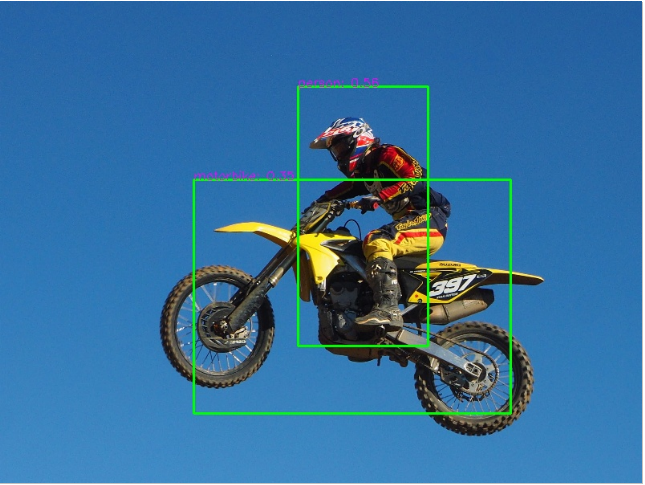

We can see that our model works quite well for this image because it can detect all relevant objects in the picture (person and motorbike), and the confidence score for each detection is also very high (0.55 for the person object and 0.36 for the motorbike). Furthermore, we can see that the bounding boxes also fit very well to the detected objects (it cover nearly entire of the detected object). And finally, we can see that our YOLO models don’t generate any false positive on background (that means don’t predict any background region as containing object). In my opinion, these are the keys for this success:
- YOLO  sees the entire image at once as opposed to looking at only a generated region proposals in the previous methods (e.g R-CNN, Faster RCNN…) . So this contextual information helps YOLO to avoid predicting false positives on background.
- YOLO may struggle with detecting small objects but it can detect objects with medium or large size very well. In our image, both objects are large enough, therefore not hard for YOLO to detect.
- Unlike classifier-based approaches, YOLO is trained on a loss function that directly corresponds to detection performance, therefore it leads to a good detection performance for our trained model on this image. 


**9_result.jpg :**

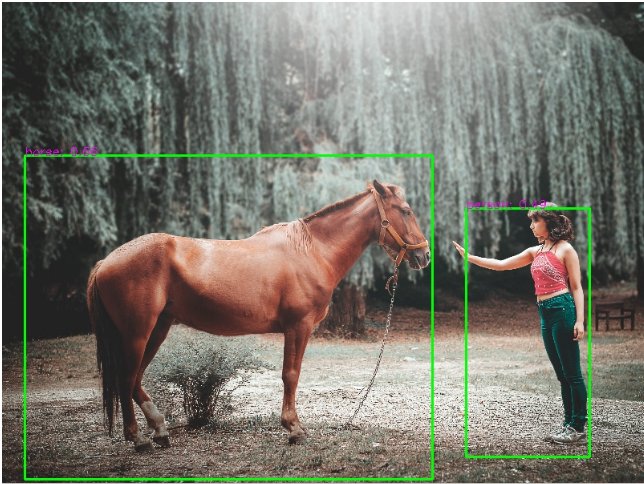

We can see that our model also works very well for this image because it can detect all relevant objects in the figure (person and horse), and the confidence score for each detection is also fairly good (0.49 for the person and 0.66 for the horse). Furthermore, we can see that the bounding box fit very well to the detected objects (it cover nearly entire of the detected object). And finally, we can see that our YOLO don’t generate any false positive on background (that means don’t predict any background region as containing object). In my opinion, these are the keys for this success:
- YOLO may struggle with detecting small objects but it can detect objects with medium or large size very well. In our image, both objects are large enough, therefore not hard for YOLO to detect.
- YOLO may struggle in the case that objects are overlapping but it works very well for objects that are clearly separated. In our image, two objects are separated very well, therefore YOLO doesn’t have much difficulty in detecting them.
- YOLO  sees the entire image at once as opposed to looking at only a generated region proposals in the previous methods. So this contextual information helps YOLO to avoid predicting false positives on background.
- Unlike classifier-based approaches, YOLO is trained on a loss function that directly corresponds to detection performance, therefore leading to a good detection performance for our trained model on this image. 


**8_result.jpg :**

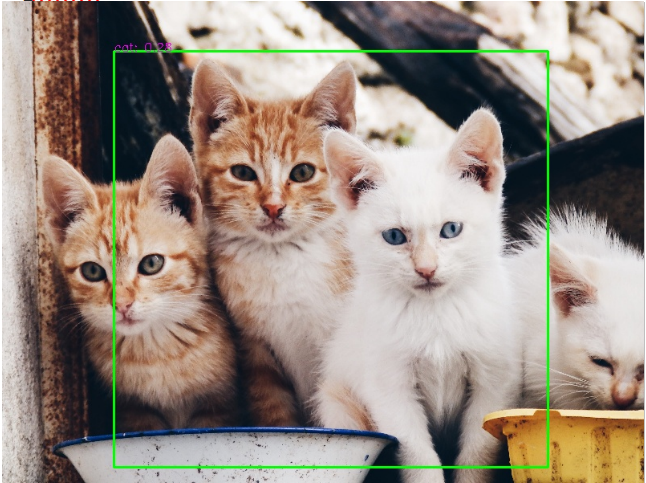

For this image, our model doesn’t work as expected because there are 4 cats but it only generate 1 bounding box and furthermore, the generated bounding box doesn’t fit well to any cat (the bounding box is quite large and doesn’t focus on any individual cat but seem to cover at least 3 cats instead). In my opinion, these are the possible reasons for this failure:
- Our YOLO model imposes strong spatial constraints on bounding box predictions since each grid cell only predicts two boxes and only have one class. This spatial constraint limits the accuracy of our model in case of nearby objects. And we can see from the above image that 4 cats stand very close to each other, and that’s maybe why our model fails.
- Regarding the first failure (model generates 1 bounding box instead of 4), I think the reason maybe that originally, our model generates bounding boxes for all cats, but the problem is that there is one box A which is very big and covers a large area of the entire image, therefore other surrounding boxes have a high IOU with A, but unfortunately those boxes have lower probability scores than A, so they are filtered out by non max suppression. Therefore eventually, only the box A survives as you can see from above image.
- Regarding the second failure (bounding box doesn’t fit well to cat object), I think the reason maybe that by inherent, YOLO struggles to localize objects precisely. Some experiments have shown that YOLO’s ability for localizing objects is much less precise than other competitors such as Fast RCNN or Faster RCNN. Therefore, YOLO may not be able to localize objects precisely for several images, and our image above is one of them.
- In our implementation, the YOLO model is only trained for 50 epochs, and the loss at final epoch (epoch 49) is still very high (train loss = 2.26 and test loss = 2.61). It maybe the reason why our model does not perform well on several images (like our image above). I think if we train our YOLO model for more epochs (such as 150 or 200), then the model’s performance would be improved significantly and failures like on above image would be reduced.


**2_result.jpg :**

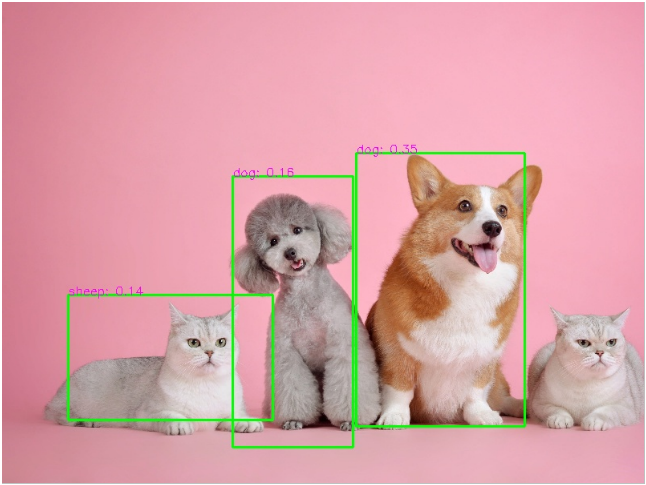

For this image, our model can detect precisely 2 dogs but it fails for detecting 2 cats (it misclassify the left cat as sheep and fails to generate bounding box for the right cat). In my opinion, these are the possible reasons for those failures:
- For the first failure (misclassify cat as sheep), the reason maybe that the color of the left cat is nearly the same as sheep’s color (white color) and our trained model’s classification ability is still not good enough, so leading to the misclassification failure. In fact for our implementation, the model is only trained for 50 epochs, and the final loss is still high ( train loss = 2.26 and test loss = 2.61). If we can train our model for more epochs (such as 150 epochs or 200 epochs), those misclassification failures might be reduced.
- For the second failure (fails to generate bounding box for the right cat), the reason maybe that at beginning, the model successes to generate bounding box for this cat but then this box is filtered out because its probability score is lower than the threshold.


#**II. Analysis on why YOLO works so fast compared to its competitors (eg RCNN, Fast-RCNN, Faster-RCNN):**

In my opinion, these are the reasons why YOLO works so fast compared to its competitors: 
- YOLO puts spatial constraints on the grid cell proposals which helps mitigate multiple detections of the same object. For example in our implementation, only 2 boxes are proposed for each cell, so leading to only 2*7*7 = 98 proposal boxes for the entire image, which is far fewer than 2000 proposal boxes generated by Selective search (an algorithm used by RCNN and Fast-RCNN). Therefore, fewer proposal boxes makes YOLO become much faster than other competitors such as RCNN or Fast RCNN.
- Some previous methods such as RCNN and Fast RCNN relies on selective search algorithm to generate bounding box proposals, but this algorithm is very slow. Instead, YOLO uses a single convolutional network to predict proposal bounding boxes, and this helps YOLO become much faster than RCNN or Fast RCNN.
- YOLO frame detection as a regression problem, straight from image pixels to bounding box coordinates and class probabilities. Therefore, it doesn’t need a complex pipeline as other methods (such as RCNN…). We simply run our YOLO neural network on a new image at test time to predict detections, so YOLO is much faster than its competitors. 
- YOLO also runs much faster than the competitor Faster RCNN due to the fact that YOLO has a much simpler architecture than Faster RCNN. 
